In [17]:
import matplotlib.pyplot as plt
import numpy as np
from lowEBMs.Packages.Configuration import importer, add_sellersparameters, parameterinterpolatorstepwise, reset
from lowEBMs.Packages.Configuration import import_parallelparameter, allocate_parallelparameter, write_parallelparameter
from lowEBMs.Packages.Variables import variable_importer
from lowEBMs.Packages.RK4 import rk4alg, controlrun
from lowEBMs.Packages.ModelEquation import model_equation
from lowEBMs.Packages.Variables import Vars,reset, trackerreset, datareset
from lowEBMs.Packages.Functions import plotmeanstd
from lowEBMs import update_plotstyle
import builtins
import matplotlib
update_plotstyle()
matplotlib.rcParams['lines.linewidth']=1.1
time_sec_year=60*60*24*365
def moving_average(signal, period):
    buffer = [np.nan] * period
    for i in range(period,len(signal)):
        buffer.append(signal[i-period:i].mean())
    return buffer

In [22]:
def func(a,b):
    data=(a)**2+b**4
    return data
    
def coremodule(config,P0,P_pert,Pmin,Pmax,labels,ZMT,GMT,grid,maxlength,targetmode,target,targetfunction,elevation,precision,num_paras,gamma0,control,controlconfig):
    F=np.reshape(np.zeros(maxlength*(2*num_paras+1)),(maxlength,2*num_paras+1))
    #F=np.reshape(np.zeros(maxlength*(num_paras+1)),(maxlength,num_paras+1))
    dF=np.reshape(np.zeros(maxlength*(num_paras)),(maxlength,num_paras))
    P=np.reshape(np.zeros(maxlength*(num_paras)),(maxlength,num_paras))
    Ptrans=np.reshape(np.zeros(maxlength*(num_paras)),(maxlength,num_paras))
    gamma=np.zeros(maxlength)
    if targetmode=='Single':
        dataout=np.reshape(np.zeros(maxlength*(2*num_paras+1)),(maxlength,(2*num_paras+1)))
    elif targetmode=='ZMT':
        dataout=np.reshape(np.zeros(maxlength*len(grid)*(2*num_paras+1)),(maxlength,(2*num_paras+1),len(grid)))
    elif targetmode=='GMT':
        dataout=np.reshape(np.zeros(maxlength*int(number_of_integration/data_readout)),(maxlength,int(number_of_integration/data_readout)))
    #data=np.reshape(np.zeros(maxlength*(2*num_paras+1)),(maxlength,2*num_paras+1))
    for i in range(maxlength):
        if i==0:
            P[i]=P0
            Ptrans[i]=(P0-Pmin)/(Pmax-Pmin)
            #Ptrans_pert1=(P_pert-Pmin)/(Pmax-Pmin)
            Ptrans_pert=Ptrans[i]*P_pert[0]/P0[0]
            #print(Ptrans_pert1,Ptrans_pert)
        #data[i][0]=(func(*P[i]))
        """for k in range(0,num_paras):
            Pk=np.zeros(num_paras)
            Pk[k]=P_pert[k]
            data[i][k+1]=(func(*P[i]+Pk))"""
  
        
        
        #for k in range(0,2*num_paras):
            #Pk=np.zeros(num_paras)
            #Pk[int(k/2)]=(-1)**k*P_pert[int(k/2)]
            #print(Pk)
            
            #data[i]=(func(*P[i]+Pk))
        data=run_model(config,P[i],P_pert,labels,ZMT,GMT,targetmode,control,controlconfig)
        dataout[i]=data
        F[i]=target_comparison(data,targetmode,target,targetfunction,grid,num_paras,elevation)

        #dF[i]=local_gradient1(F[i],P_pert)
        dF[i]=local_gradient1(F[i],Ptrans_pert)
        
        if i==0:
            gamma[i]=gamma0
        else:
            #gamma[i]=step_weighting(dF[i-1],dF[i],P[i-1],P[i])
            gamma[i]=step_weighting(dF[i-1],dF[i],Ptrans[i-1],Ptrans[i])
            
        if precision_check(dF[0],dF[i],precision):
            print('stop',i)
            P=P[:i]
            Ptrans=Ptrans[:i]
            F=F[:i]
            gamma=gamma[:i]
            break
                
        #P_next=new_parameters(P[i],gamma[i],dF[i])        
        Ptrans_next=new_parameters(Ptrans[i],gamma[i],dF[i])

        for k in range(num_paras):
            if Ptrans_next[k]<0:
                Ptrans_next[k]=0.
            if Ptrans_next[k]>1:
                Ptrans_next[k]=1.

        if i<maxlength-1:
            Ptrans[i+1]=Ptrans_next
            P[i+1]=Pmin+Ptrans_next*(Pmax-Pmin)
            #P[i+1]=P_next    
            print(P[i+1])
            print(Ptrans[i+1])
    return F, dF, P , Ptrans, gamma, dataout
    
def target_comparison(data,targetmode,target,targetfunction,grid,num_paras,elevation):
    F=np.zeros(2*num_paras+1)
    if targetfunction=='LeastSquare':
        if targetmode=='Single':
            F=(np.array(data)-target)**2
        elif targetmode=='ZMT':
            for i in range(len(data)):
                data[i]=data[i]+elevation
            for i in range(len(F)):
                F[i]=np.sum(((data[i]-target)*np.cos(grid*np.pi/180)/np.mean(np.cos(grid*np.pi/180)))**2)
        elif targetmode=='GMT':
            for i in range(len(F)):
                F[i]=np.sum((data[i]-target)**2)

    print(F)
    return F

def parameter_gradient(P0,P1):
    dP=P1-P0
    return dP

def local_gradient(F,P_pert):
    dF=(F[1:]-F[0])/P_pert
    return dF

def local_gradient1(F,P_pert):
    dF=np.zeros(len(P_pert))
    for k in range(len(P_pert)):
        #print(2*(k+1)-1,2*(k+1))
        #print(F[2*(k+1)-1]-F[2*(k+1)])
        dF[k]=(F[2*(k+1)-1]-F[2*(k+1)])/(2*P_pert[k])
    return dF

def step_weighting(dF0,dF1,P0,P1):
    gamma=np.abs(np.dot(P1-P0,dF1-dF0)/np.dot(dF1-dF0,dF1-dF0))
    return gamma

def precision_check(dF0,dF,precision):
    dFabs=np.sqrt(np.dot(dF,dF))
    dF0abs=np.sqrt(np.dot(dF0,dF0))
    if dFabs/dF0abs <= precision:
        return True
    
def new_parameters(P,gamma,dF):
    #print(gamma,dF)
    P_next=P-gamma*dF
    return P_next
#def gradient_descent(xn,)

def run_model(config,P,P_pert,labels,ZMT,GMT,targetmode,control,controlconfig):
    
    if control==True:
        config_CTRL=importer(controlconfig)
        variable_importer(config_CTRL,parallel=False)

        config_CTRL,ParasCTRL=add_sellersparameters(config_CTRL,\
                                        parameterinterpolatorstepwise,'SellersParameterization.ini',2,0,True,True)
        config_CTRL=add_parameters(config_CTRL,P,labels)
        data_CTRL=rk4alg(model_equation,config_CTRL['eqparam'],config_CTRL['funccomp'])
        ZMT,GMT=data_CTRL[1][-1],data_CTRL[2][-1]
        
    P_config=reshape_parameters(P,P_pert)
    setup={'number_of_parameters': len(P), 'number_of_cycles': 1, 'number_of_parallels': len(P)*2+1}
    
    datareset()
    variable_importer(config,parallel=True,parallel_config=setup)
    config=add_parameters(config,P_config,labels)
    
    if control==True:
        Vars.T,Vars.T_global=np.array([ZMT]*int(len(P)*2+1)),np.array([GMT]*int(len(P)*2+1))
    else:
        Vars.T,Vars.T_global=ZMT,GMT
    data=rk4alg(model_equation,config['eqparam'],config['funccomp'])
    if targetmode=='Single':
        data_out=data[2][-1]
    elif targetmode=='ZMT':
        data_out=data[1][-1]
    elif targetmode=='GMT':
        print(data[0][int(number_of_integration/2/data_readout)]/time_sec_year)
        data_out=data[2][:-1,0]-data[2][0,0]

    return data_out

def reshape_parameters(P,P_pert):
    num_para=len(P)
    #Pk=np.zeros(num_paras)
    P_config=np.reshape(np.zeros(num_para*(2*num_para+1)),(num_para,2*num_para+1))
    #Ensemble_parameters=dict()
    for i in range(num_para):
        #Pk[int(k/2)]=(-1)**k*P_pert[int(k/2)]
        P_config[i]=np.array([P[i]]*(2*num_para+1))
        P_config[i][i*2+1]=P[i]+P_pert[i]
        P_config[i][i*2+2]=P[i]-P_pert[i]
    #print(P_config)
    """
    j=1
    for i in list(x0.keys()):
        Ensemble_parameters.update({i:np.array([x0[i]]*(num_para+1))})
        Ensemble_parameters[i][j]=x0[i]+dx[i]
        j+=1
    """                             
    return P_config
             
def add_parameters(config,P_config,labels):
    num_para=len(P_config)
    """for i in list(Parameterlabels.keys()):
        for j in Parameterlabels[i]:
            config['funccomp']['funcparam'][i][j]=Ensemble_parameters"""
    for i in range(num_para):
        if labels[i][0][:4]=='func':
            config['funccomp']['funcparam'][labels[i][0]][labels[i][1]]=P_config[i]
        if labels[i][0]=='eqparam':
            config[labels[i][0]][labels[i][1]]=P_config[i]
    return config
#Parameterlabels={'func1':['A','B'],'func2':['factor_oc','factor_kwv','factor_kair']}
#Parameterlabels=[['func1','a'],['func1','b'],['func2','factor_oc'],['func2','factor_kwv'],['func2','factor_kair']]
#Start_parameters=[230,2.5,1,1,1]
#Start_pertubation=[1,0.1,0.05,0.05,0.05]
#y=reshape_parameters(Start_parameters,Start_pertubation) 
#config_new=add_parameters(Config_Try1_base,y,Parameterlabels)
#print(y)
#print(config_new)

In [41]:
precision=1e-7
maxlength=int(1e4)
target=0
num_params=2
P0=np.array([2,2])
P_pert=P0/100
gamma0=1e-3
F,dF,P,gamma,data=coremodule(0,P0,P_pert,0,0,0,maxlength,target,'LeastSquare',precision,num_params,gamma0)
print(P[-1],F[-1])
print(target,func(*P[-1]))
#print(gamma)

[2. 2.]
[1.8399968  0.71925753]
[1.81281913 0.70825445]
[1.31510759 0.51297074]
[1.03693674 0.45577368]
[0.77060153 0.40704015]
[0.58343549 0.37420155]
[0.43692919 0.34781564]
[0.32715967 0.32661492]
[0.24345494 0.30874067]
[0.1798926  0.29334745]
[0.1313287  0.27972058]
[0.09406076 0.26734682]
[0.06525677 0.25576543]
[0.04286612 0.24452764]
[0.02551825 0.23313945]
[0.01256549 0.22105196]
[0.00407107 0.20774095]
stop 18
[0.00407107 0.20774095] [3.53079192e-06 5.96279173e-06 4.47829184e-06 7.32595175e-06
 1.58483182e-06]
0 0.001879040160209674


In [3]:
config_CTRL=importer('Dev_Data/Optimization/Try1_Budyko_CTRL.ini')
#setup={'number_of_parameters': 5, 'number_of_cycles': 1, 'number_of_parallels': 6}
#allocated,setup=allocate_parallelparameter(raw)
variable_importer(config_CTRL,parallel=False)#,parallel_config=setup)
config_CTRL,ParasCTRL=add_sellersparameters(config_CTRL,\
                                    parameterinterpolatorstepwise,'SellersParameterization.ini',2,0,True,True)

labels=[['eqparam','c_ao'],['func1','a'],['func1','b'],['func2','factor_oc'],['func2','factor_kwv'],['func2','factor_kair']]
#P0=np.array([205,1.5,1,1,1])
P0=np.array([70*4.2e6,205,1.5,1.165,1.165,1.165])
#for i in range(2):
#    Try['funccomp']['funcparam'][labels[i][0]][labels[i][1]]=P0[i]
#P_pert=P0/1000
#P_config=reshape_parameters(P0,P_pert)
config_CTRL=add_parameters(config_CTRL,P0,labels)
trackerreset()
builtins.Runtime_Tracker=0
data_CTRL=rk4alg(model_equation,config_CTRL['eqparam'],config_CTRL['funccomp'])

Loading Configuration from: Dev_Data/Optimization/Try1_Budyko_CTRL.ini
Loading Parameters from: /Home/siv32/bsc029/.local/lib/python3.6/site-packages/lowEBMs/Tutorials/Config/Data/SellersParameterization.ini
Starting simulation...



Simulation finished within 49.36830019950867 seconds


In [20]:
Zero_ZMT,Zero_GMT=np.array([data_CTRL[1][-1]]*13),np.array([data_CTRL[2][-1]]*13)
#out=np.reshape(np.zeros(19*6),(6,19))
#for i in range(6):
#    out[i]=[Zero_GMT[i],*Zero_ZMT[i]]
#np.savetxt('Data/Optimization_InputTemp.txt',out,delimiter=',')"""
#print(Zero_ZMT,Zero_GMT)

In [24]:
labels=[['func1','a'],['func1','b'],['func2','factor_oc'],['func2','factor_kwv'],['func2','factor_kair']]
P0=np.array([70*4.2e6,205,1.5,1.165,1.165,1.165])
P_pert=P0/1000
Pmin=np.array([30*4.2e6,190,1.3,0.9,0.9,0.9])
Pmax=np.array([100*4.2e6,250,4,1.3,1.3,1.3])
precision=1e-6
maxlength=int(30)
targetmode='Single'
target=286.39
targetfunction='LeastSquare'
num_params=6
gamma0=1e-3
setup={'number_of_parameters': 6, 'number_of_cycles': 1, 'number_of_parallels': 13}
grid=0
elevation=0
control=False
controlconfig=0

config_base=importer('Dev_Data/Optimization/Try1_Budyko.ini')
variable_importer(config_base,parallel=True,parallel_config=setup)
config_base,ParasCTRL=add_sellersparameters(config_base,\
                                    parameterinterpolatorstepwise,'SellersParameterization.ini',2,0,True,True)

F, dF, P, Ptrans , gamma, data=coremodule(config_base,P0,P_pert,Pmin,Pmax,labels,Zero_ZMT,Zero_GMT,grid,\
    maxlength,targetmode,target,targetfunction,elevation,precision,num_params,gamma0,control,controlconfig)

Loading Configuration from: Dev_Data/Optimization/Try1_Budyko.ini
Loading Parameters from: /Home/siv32/bsc029/.local/lib/python3.6/site-packages/lowEBMs/Tutorials/Config/Data/SellersParameterization.ini
Starting simulation...


KeyboardInterrupt: 

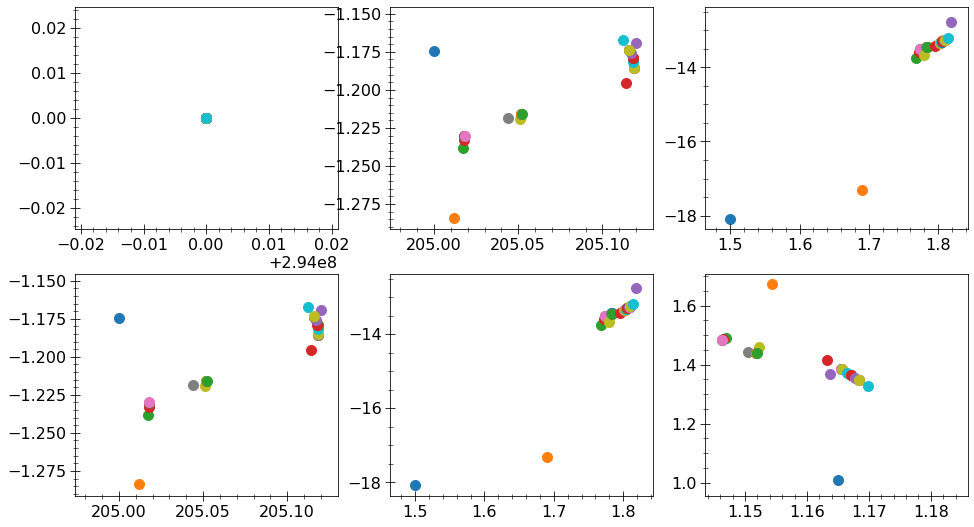

In [53]:
#print(local_gradient1(data[2],P_pert))
fig,ax=plt.subplots(2,3,figsize=(16,9))
for k in range(2):
    for j in range(3):
        for i in range(30):
            ax[k][j].scatter(P[i][k+j],local_gradient1(data[i],P_pert)[k+j])
#plt.plot(np.arange(30),data[:,0]-target)
#plt.yscale('log')

In [238]:
data=run_model(config_base,P0,P_pert,labels)

Starting simulation...



Simulation finished within 11.577050924301147 seconds


In [239]:
print(data)

[201.63311768 201.23311721 204.38376606 201.63311766 201.63311767
 201.63311758]


In [140]:
Config_Try1_base=importer('Dev_Data/Optimization/Try1_Budyko.ini')
setup={'number_of_parameters': 5, 'number_of_cycles': 1, 'number_of_parallels': 6}
#allocated,setup=allocate_parallelparameter(raw)
variable_importer(Config_Try1_base,parallel=True,parallel_config=setup)
Config_Try1,ParasCTRL=add_sellersparameters(Config_Try1_base,\
                                    parameterinterpolatorstepwise,'SellersParameterization.ini',2,0,True,True)

Parameterlabels=[['func1','a'],['func1','b'],['func2','factor_oc'],['func2','factor_kwv'],['func2','factor_kair']]
Initial_parameters=[230,2.5,1,1,1]
Initial_pertubation=[1,0.1,0.05,0.05,0.05]
Start_parameters=[]
Start_pertubation=[]
Ensemble_parameters=[]
Start_parameters.append(Initial_parameters)
Start_pertubation.append(Initial_pertubation)
Target=15+273.15
for i in range(2):
    #raw=import_parallelparameter('Dev_Data/Volc_Rout/Ensemble_Budyko_Pinatubo.ini')
    Start_parameters.append(x)
    Start_pertubation.append(dx)
    Ensemble_parameters.append(reshape_parameters(Start_parameters[i],Start_pertubation[i]))
    Config_new=add_parameters(Config_Try1,Ensemble_parameters[i],Parameterlabels)
    #Config_Try1=write_parallelparameter(Config_Try1,allocated,setup)
    
    trackerreset()
    builtins.Runtime_Tracker=0
    Try1=rk4alg(model_equation,Config_new['eqparam'],Config_new['funccomp'])
    
    T=Try1[2][-1]
    S=deviation_function(T,Target,'Residual')
    dF=calculate_gradient(S,0)
    x,dx=new_parameters(Start_parameters[i],Start_pertubation[i],dF,0)
    
    """setup={'number_of_parameters': 4, 'number_of_cycles': 1, 'number_of_parallels': 4}
    variable_importer(configFuncDiffCTRL,parallel=True,parallel_config=setup)

    configFuncDiffCTRL,ParasCTRL=add_sellersparameters(configFuncDiffCTRL,parameterinterpolatorstepwise,'SellersParameterization.ini',5,0,True,True)

    Func1_4=np.array([[True,False,False,False],[False,True,False,False],[False,False,True,False],[False,False,False,True]])
    for i in range(1,5):
        configFuncDiffCTRL['funccomp']['funcparam']['func'+str(i)]['activation']=Func1_4[i-1]"""
    
    

Loading Configuration from: Dev_Data/Optimization/Try1_Budyko.ini
Loading Parameters from: /Home/siv32/bsc029/.local/lib/python3.6/site-packages/lowEBMs/Tutorials/Config/Data/SellersParameterization.ini


NameError: name 'dx' is not defined

In [392]:
next_x_0 = 1  # We start the search at x=6
next_x=next_x_0
next_y_0 = 4
next_y=next_y_0
gamma = 0.001  # Step size multiplier
precision = 1e-8  # Desired precision of result
max_iters = 10000  # Maximum number of iterations

# Derivative function
#F = lambda x,y: x**2+y**4
#dfx = lambda x: 2*x
#dfy = lambda y: 4*y**3
F = lambda x,y: x**2+y**4+x**2*y**2
dfx = lambda x,y: 2*x+2*x*y**2
dfy = lambda x,y: 4*y**3+x**2*2*y

x=[]
y=[]
for i in range(max_iters):
    current_x = next_x
    current_y = next_y
    x.append(current_x)
    y.append(current_y)
    if i==0:
        df0=np.sqrt(dfx(current_x,current_y)**2+dfy(current_x,current_y)**2)
    if i>=1:
        gamma=abs((x[i]-x[i-1])*(dfx(x[i],y[i])-dfx(x[i-1],y[i-1]))+(y[i]-y[i-1])*(dfy(x[i],y[i])-dfy(x[i-1],y[i-1])))\
                    /((dfx(x[i],y[i])-dfx(x[i-1],y[i-1]))**2+(dfy(x[i],y[i])-dfy(x[i-1],y[i-1]))**2)
        print(gamma)
    #print(np.sqrt(dfx(current_x,current_y)**2+dfy(current_x,current_y)**2))
        #gamma_y=abs())/abs(dfy(y[i])-dfy(y[i-1]))**2
    next_x = current_x - gamma * dfx(current_x,current_y)
    next_y = current_y - gamma * dfy(current_y,current_y)
    Fabs=abs(F(next_x,next_y)-F(current_x,current_y))
    df=np.sqrt(dfx(current_x,current_y)**2+dfy(current_x,current_y)**2)
    if df/df0 <= precision:
        break
    #if abs(step_x)<= precision and abs(step_y)<= precision :
    #    break

print("Minimum at", next_x, next_y, i)
t=np.linspace(-10,10,100)
#plt.plot(t,df(t))

0.005630112809163453
0.00993827628197613
0.024922214766503567
0.04759448143982094
0.10029767881882037
0.1940339476686329
0.35812582172776086
0.47898058414066236
0.636372168641202
2.2330326209482934
4.165174655667334
0.7898948347868491
0.4978253243717003
0.49875530392581874
15.883618570096505
27.582652459850706
68.4072107374806
0.5219913560671585
0.4998198606455038
0.4998536319935656
232.14855328264395
398.1532080849546
1158.4246746119416
Minimum at -1.8385907364006245e-06 0.004576915113284614 23


(-1, 1)

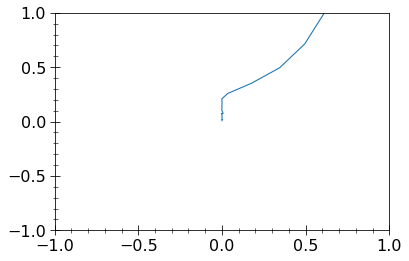

In [6]:
plt.plot(x,y)
plt.scatter(next_x_0,next_y_0)
plt.xlim(-1,1)
plt.ylim(-1,1)

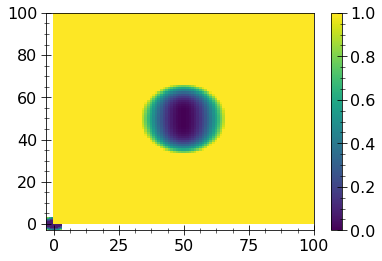

In [69]:
xx=np.array([np.linspace(-3,3,100)]*100)
yy=np.transpose(np.array([np.linspace(-3,3,100)]*100))
z=F(xx,yy)
#print(z)
plt.contourf(xx,yy,z)
heatmap = plt.pcolor(z)
cbar = plt.colorbar(heatmap)
plt.clim(0,1)
#plt.cbar()

625000
629392.5438200647
625017.5000699877


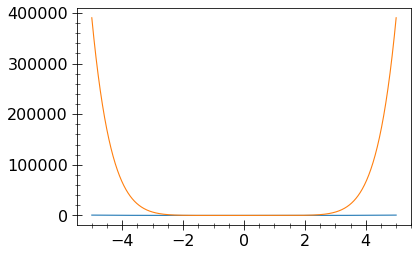

In [388]:
x=np.linspace(-5,5,1000)
x0=5
plt.plot(x,x**4)
def Res(x,x_t):
    S=(x-x_t)**2
    return S
plt.plot(x,Res(x**4,0))
S=[Res(x0**4,0),Res((x0+0.01)**4,0),Res((x0-0.01)**4,0)]
print(2*(x0**4-0)*4*x0**3)
print((S[1]-S[0])/0.01)
print((S[1]-S[2])/0.02)
#print(4*x0**3)
#print(((x0+0.01)**4-x0**4)/(0.01))
#print(((x0+0.01)**4-(x0-0.01)**4)/(2*0.01))